100%|██████████| 1/1 [03:34<00:00, 214.24s/it]


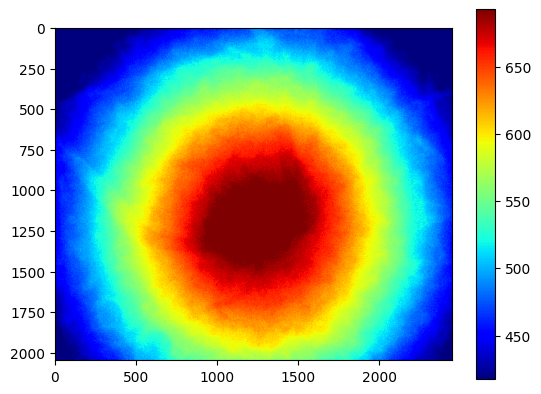

In [2]:
import os
from tqdm import tqdm
import cv2
import multiprocessing
from metadata import Metadata
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.ndimage import gaussian_filter,percentile_filter,median_filter,minimum_filter

base_path = '/orangedata/Images2024/Zach/dredFISH/'
dataset_path = os.path.join(base_path,'Orange1s_PBS.ABC_PFA.DEF_2024Mar26')
image_metadata = Metadata(dataset_path)
fnames = image_metadata.image_table[(image_metadata.image_table.Channel=='FarRed')&(image_metadata.image_table.Exposure==1000)].filename
del image_metadata
fnames = fnames[0:50]
def avg_images(fnames):
    img = ''
    for i,fname in enumerate(tqdm(fnames)):
        temp = cv2.imread(fname,cv2.IMREAD_UNCHANGED)
        temp = temp.astype(float)
        thresh = np.percentile(temp,95)
        temp[temp>thresh] = thresh
        thresh = np.percentile(temp,5)
        temp[temp<thresh] = thresh
        bkg = gaussian_filter(temp,50)
        temp = temp-bkg
        temp = torch.tensor(temp)
        thresh = np.percentile(temp,95)
        temp[temp>thresh] = thresh
        thresh = np.percentile(temp,5)
        temp[temp<thresh] = thresh
        temp = temp + torch.tensor(bkg)
        if isinstance(img,str):
            img = temp
        else:
            img+=temp
    return img/len(fnames)
n_cpu = 1
chunksize = 200
Input = [fnames[i:i+chunksize].tolist() for i in range(0, len(fnames), chunksize)]
with multiprocessing.Pool(n_cpu) as p:
    img = ''
    for i,temp in enumerate(tqdm(p.imap(avg_images,Input),total=len(Input))):
        if isinstance(img,str):
            img = temp
        else:
            img+=temp
img = (img/len(Input)).numpy()
vmin,vmax = np.percentile(img.ravel(),[5,95])
plt.imshow(img,vmin=vmin,vmax=vmax,cmap='jet')
plt.colorbar()
plt.show()

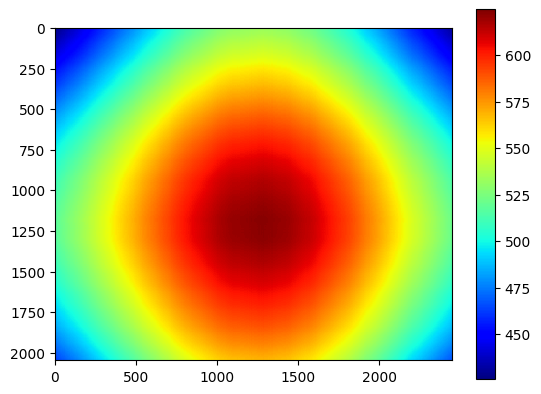

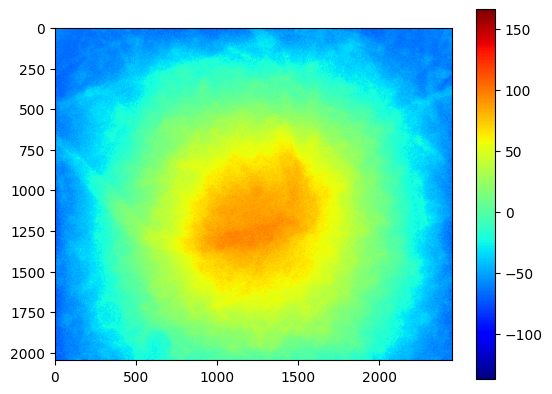

In [14]:
plt.imshow(((np.ones_like(img)*img.mean(0))+(np.ones_like(img).T*img.mean(1)).T)/2,cmap='jet')
plt.colorbar()
plt.show()

plt.imshow(img-((np.ones_like(img)*img.mean(0))+(np.ones_like(img).T*img.mean(1)).T)/2,cmap='jet')
plt.colorbar()
plt.show()

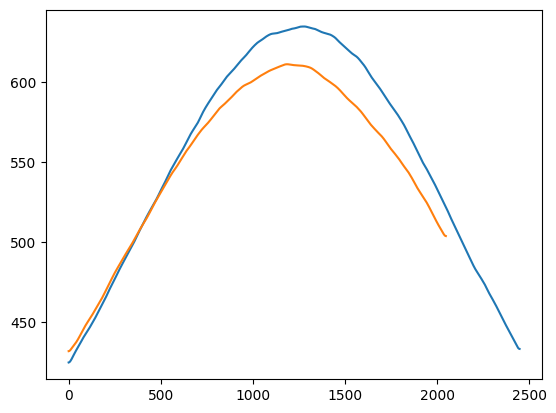

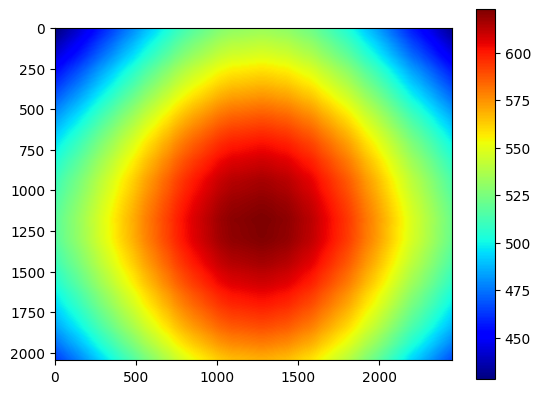

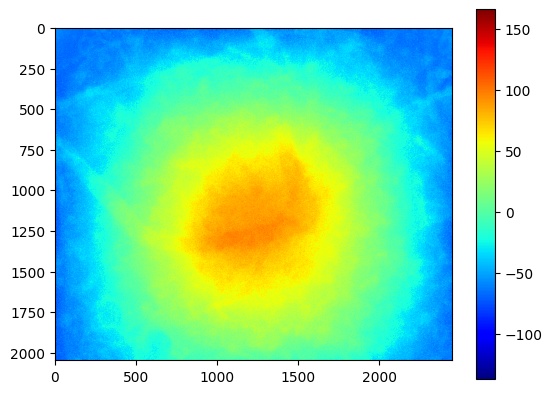

In [23]:
ff_x = gaussian_filter(np.mean(img,axis=0),10)
ff_y = gaussian_filter(np.mean(img,axis=1),10)
plt.plot(range(ff_x.shape[0]),ff_x)
plt.plot(range(ff_y.shape[0]),ff_y)
plt.show()
ff = ((np.ones_like(img)*ff_x)+(np.ones_like(img).T*ff_y).T)/2

plt.imshow(ff,cmap='jet')
plt.colorbar()
plt.show()

plt.imshow(img-ff,cmap='jet')
plt.colorbar()
plt.show()

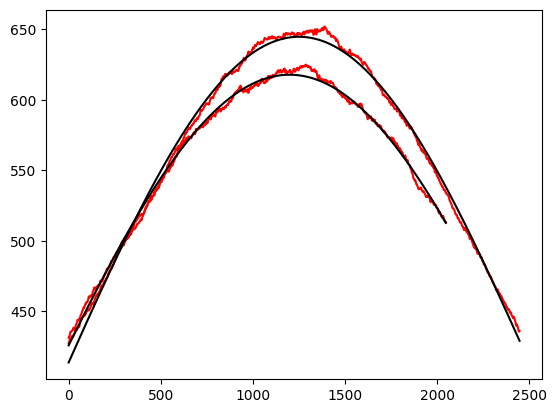

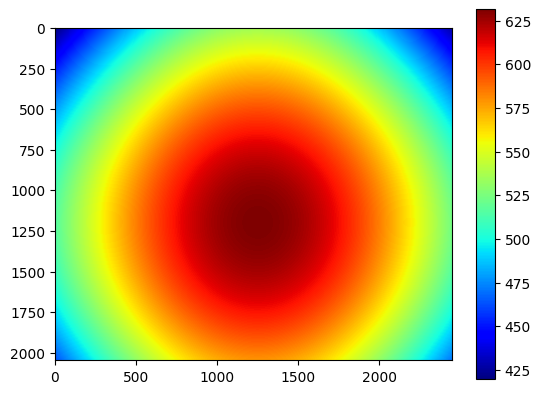

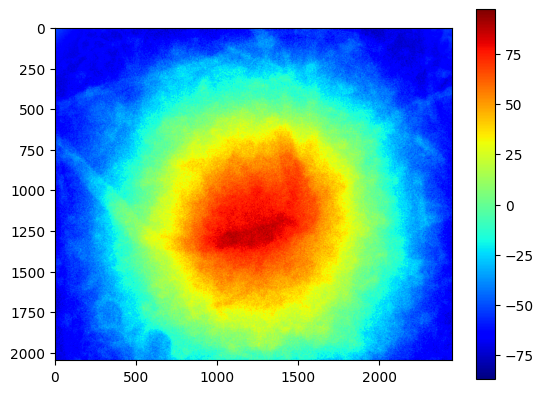

In [36]:
ff_x = gaussian_filter(np.percentile(median_filter(img,5),50,axis=0),1)
ff_y = gaussian_filter(np.percentile(median_filter(img,5),50,axis=1),1)
plt.plot(range(ff_x.shape[0]),ff_x,c='r')
plt.plot(range(ff_y.shape[0]),ff_y,c='r')
from scipy.optimize import curve_fit
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 2 / stddev)**2)
x_data = np.arange(ff_x.shape[0])
popt, _ = curve_fit(gaussian, x_data, ff_x, p0=[1, np.mean(x_data), np.std(x_data)])
ff_x = gaussian(x_data, *popt)
x_data = np.arange(ff_y.shape[0])
popt, _ = curve_fit(gaussian, x_data, ff_y, p0=[1, np.mean(x_data), np.std(x_data)])
ff_y = gaussian(x_data, *popt)


plt.plot(range(ff_x.shape[0]),ff_x,c='k')
plt.plot(range(ff_y.shape[0]),ff_y,c='k')
plt.show()
ff = ((np.ones_like(img)*ff_x)+(np.ones_like(img).T*ff_y).T)/2

plt.imshow(ff,cmap='jet')
plt.colorbar()
plt.show()

plt.imshow(median_filter(img,5)-ff,cmap='jet')
plt.colorbar()
plt.show()

In [25]:
import os
from tqdm import tqdm
import cv2
import multiprocessing
from metadata import Metadata
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.ndimage import gaussian_filter,percentile_filter,median_filter,minimum_filter
from dredFISH.Processing.Section import *
base_path = '/orangedata/Images2024/Zach/dredFISH/'
dataset_path = os.path.join(base_path,'Orange1s_PBS.ABC_PFA.DEF_2024Mar26')
image_metadata = Metadata(dataset_path)